# Overview
Siamese networks : Find out similarity of images.
Steps:
1.Load Images from kaggle repository
2.Parse meta data and load images
3.Create data to use in one shot learning
4.Prepare siamese net model
5.Evaluate using precision roc curve

*This code uses a simple model to ilustrate the steps of siamese net one shot learning.

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications import VGG16
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy.random as rng
import numpy as np
import random
import shutil
import cv2
import os

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Load Data
Separate covid and non covid data

In [2]:
df=pd.read_csv('/kaggle/input/covid-chest-xray/metadata.csv')
#Discard some attributes
df=df[['patientid','finding','modality','filename']]
root_dir_images = '/kaggle/input/covid-chest-xray/images/'

data=[]
labels=[]
i=0

#loop over images address stored in the list and load data
for imageName in os.listdir(root_dir_images):
    i=i+1
    image=cv2.imread(os.path.join(root_dir_images,imageName))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cover = cv2.resize(image, (224, 224))
    
    #keep images and corresponding labels 
    for (j, row) in df.iterrows():
        if (row["filename"] == imageName and row["modality"]=="X-ray"):
            data.append(cover)
            #row["finding"] consists of labels like COVID,SARS etc
            if ((row["finding"]=="COVID-19, ARDS") or (row["finding"]=="COVID-19")):
                labels.append("COVID-19")
            else:
                labels.append("Non Covid")
                #labels.append(row["finding"])   

                #print(imageName+" "+row["finding"])
                #break
    
    #a=df.loc[(df['filename']==imageName),'finding']
    #print(a)
print('Data Loaded')   

Data Loaded


# Plot Sample loaded image data 

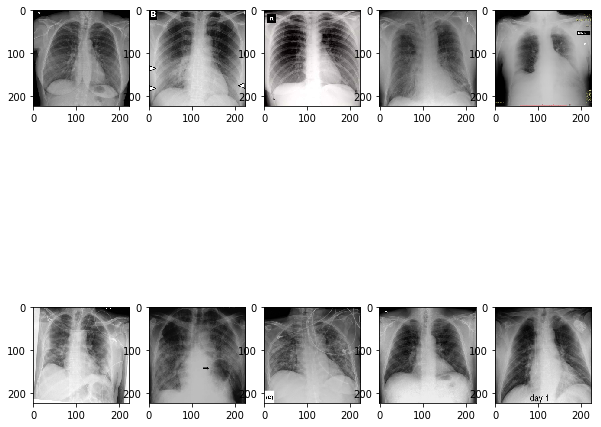

In [9]:
#plot loaded image data
fig=plt.figure(figsize=(10,10))
columns = 2
rows = 5
for j,img in enumerate(data[10:20],1):
    #print(j)
    fig.add_subplot(columns,rows,j)
    plt.imshow(img)
plt.show()

# Encode text labels to integers

In [10]:
#integer encoding of labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
list(le.classes_)

#convert text to integers
y=le.transform(labels)
print(le.classes_)
print(le.transform(le.classes_))
print(y)

#array([2, 2, 1])
#list(le.inverse_transform([2, 2, 1]))  #Get back the text labels

########IGNORE THIS BLOCK#############
##binary conversion of labels
##label binarizer converts the labels into one hot vector directly
#lb = LabelBinarizer()
##one hot encoded data labels. There are 6 findings including: covid19,sars,ards etc.
#y=lb.fit_transform(df['finding'])
##y=to_categorical(y)
#print(y[0])

['COVID-19' 'Non Covid']
[0 1]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0
 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0]


# Check dimension consistency of data and labels and convert to integers

In [11]:
#check dimension of data and labels
data=np.array(data) #(308, 224, 224, 3)
y=np.array(y) #(308,)
print(data.shape)
print(y.shape)

(328, 224, 224, 3)
(328,)


# Generate train test split

In [12]:
from sklearn.model_selection import train_test_split
#data_train = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
#X_full = data_train.iloc[:,1:] # 6000,784
#y_full = data_train.iloc[:,:1] # 6000,1

X_full=data
y_full=y

x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.3)

#x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
#x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = y_train.astype('int')
y_test = y_test.astype('int')

print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

print(X_full.shape)
print(y_full.shape)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)


# reorganize by groups
# train_groups contains the images
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups shape:', [x.shape[0] for x in train_groups])
print('test groups shape:', [x.shape[0] for x in test_groups])

Training (229, 224, 224, 3) 1.0
Testing (99, 224, 224, 3) 1.0
(328, 224, 224, 3)
(328,)
(229, 224, 224, 3)
(229,)
(99, 224, 224, 3)
(99,)
train groups shape: [182, 47]
test groups shape: [83, 16]


# Save and load variables

In [13]:
import pickle

# Saving the objects:
with open('objs1.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([x_train, y_train, x_test, y_test], f)
    
# Getting back the objects:
with open('objs1.pkl','rb') as f:  # Python 3: open(..., 'rb')
    x_train, y_train, x_test, y_test = pickle.load(f)

### Batch Generation
Here the idea is to make usuable batches for training the network. We need to create parallel inputs for the $A$ and $B$ images where the output is the distance. Here we make the naive assumption that if images are in the same group the similarity is 1 otherwise it is 0.

If we randomly selected all of the images we would likely end up with most images in different groups.

In [14]:
def gen_random_batch(in_groups, batch_halfsize = 3):
    #half of the batch is from group a and rest from group b
    #in_groups: testImages or trainImages or validationImages grouped according to labels
    out_img_a, out_img_b, out_score, a_group_label, b_group_label = [], [], [], [], []
    #count of total groups according to labels
    #samples grouped according to dimension in ((in_groups))
    all_groups = list(range(len(in_groups)))   
    #print(all_groups)
    #50% true 50% false
    for match_group in [True, False]:          
        #select total batch_halfsize group numbers(we will take batch_halfsize images according to generated groupnumbers)
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        #select some images from that group(group_idx) in group_a
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        a_group_label.append(group_idx);
        
        if match_group:  #generate same group pair
            #put same images(index)from group_a above, in group_b (to make same group pair)
            b_group_idx = group_idx
            b_group_label.append(b_group_idx)
            #put 1 as score value for all the (group_a,group_b) pairs
            out_score += [1]*batch_halfsize
        else:            #generate different group pair
            #put non group_a images(indx) in group_b (to make different group pair)
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            #put same images(indx) from group_a above, in group_b (to make same group pair)
            b_group_idx = non_group_idx
            b_group_label.append(b_group_idx)
            #put 0 as score value for all the (group_a,group_b) pairs
            out_score += [0]*batch_halfsize
        
        #finally put the images(from index selected from if else block) in group_b    
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    
    #return group_a and group_b images along with corresponding scores
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0),np.stack(a_group_label,0),np.stack(b_group_label,0)

## Validate Data
Here we make sure the generator is doing something sensible, we show the images and their similarity percentage.

In [15]:
#print(train_groups)  #samples grouped according to dimension
print(len(train_groups))
print(len(train_groups[0]))
print(len(train_groups[1]))
all_groups = list(range(len(train_groups)))
print(all_groups)
pv_a, pv_b, pv_sim, gl_a, gl_b = gen_random_batch(train_groups, 3)
print(gl_b)
#pv_a, pv_b, pv_sim, gl_a, gl_b = gen_four_way_batch(train_groups)
#print(gl_b)

2
182
47
[0, 1]
[[1 1 0]
 [0 0 0]]


(4, 224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


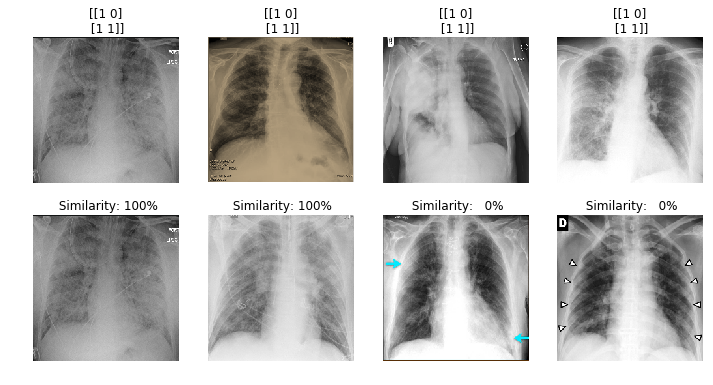

In [17]:
pv_a, pv_b, pv_sim, gl_a, gl_b = gen_random_batch(train_groups, 2)
print(pv_a.shape) #print(pv_a.shape[0]) is how many images are there


c_a=pv_a[0,:]
print(c_a.shape)

fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    print(c_a.shape) #print(pv_a.shape[0])

    ax1.imshow(c_a[:,:]) #ax1.imshow(c_a[:,:,0]) shows 1st channel image  #ax1.imshow(c_a[:,:,1]) shows 2nd channel image  #ax1.imshow(c_a[:,:]) shows black white image
    ax1.set_title(gl_a[:])
    ax1.axis('off')
    ax2.imshow(c_b[:,:])
    ax2.set_title('\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

# Feature Generation
Here we make the feature generation network to process images into features. The network starts off randomly initialized and will be trained to generate useful vector features from input images (_hopefully_)

In [18]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 8)       224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 8)       32        
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 16)      1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 220, 220, 16)      64        
_________________________________________________________________
activation_2 (Activation)    (None, 220, 220, 16)      0         
__________

# Siamese Model
We apply the feature generating model to both images and then combine them together to predict if they are similar or not. The model is designed to very simple. The ultimate idea is when a new image is taken that a feature vector can be calculated for it using the _FeatureGenerationModel_. All existing images have been pre-calculated and stored in a database of feature vectors. The model can be applied using a few vector additions and multiplications to determine the most similar images. These operations can be implemented as a stored procedure or similar task inside the database itself since they do not require an entire deep learning framework to run.

In [19]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Model)  (None, 32)           2885216     ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           FeatureGenerationModel[1][0]     
          

In [20]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

## Visual Model Feedback
Here we visualize what the model does by taking a small sample of randomly selected A and B images the first half from the same category and the second from different categories. We then show the actual distance (0 for the same category and 1 for different categories) as well as the model predicted distance. The first run here is with a completely untrained network so we do not expect meaningful results.

[[1 1 0]
 [1 1 1]]
[[1 1 0]
 [0 0 0]]
[[ 0.50187725]
 [ 0.49554655]
 [ 0.49594533]
 [ 0.49627277]
 [ 0.49376819]
 [ 0.49641952]]
(4, 224, 224, 3)


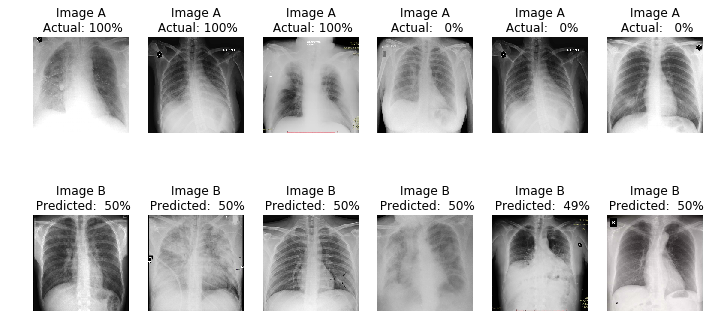

In [21]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim, gl_a, gl_b = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    print(gl_a)
    print(gl_b)
    print(pred_sim)
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()
print(pv_b.shape)

In [23]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim, gl_a, gl_b = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
        
    class StopCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('acc')>=0.90):
                print("\nReached 90% accuracy so cancelling training!")
                self.model.stop_training = True
                
    callbacks = StopCallback()

# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim, gl_a, gl_b = gen_random_batch(test_groups, 4)
loss_history = similarity_model.fit_generator(siam_gen(train_groups), 
                               steps_per_epoch = 10,
                               validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 10,
                                             verbose = True)

Epoch 1/10
10/10 [==============================] - 95s 10s/step - loss: 0.7151 - mean_absolute_error: 0.4988 - val_loss: 0.6930 - val_mean_absolute_error: 0.4995
Epoch 2/10
10/10 [==============================] - 93s 9s/step - loss: 0.7348 - mean_absolute_error: 0.5088 - val_loss: 0.6920 - val_mean_absolute_error: 0.4987
Epoch 3/10
10/10 [==============================] - 94s 9s/step - loss: 0.7272 - mean_absolute_error: 0.5051 - val_loss: 0.6926 - val_mean_absolute_error: 0.4987
Epoch 4/10
10/10 [==============================] - 93s 9s/step - loss: 0.7240 - mean_absolute_error: 0.5045 - val_loss: 0.6919 - val_mean_absolute_error: 0.4985
Epoch 5/10
10/10 [==============================] - 94s 9s/step - loss: 0.7214 - mean_absolute_error: 0.5047 - val_loss: 0.6919 - val_mean_absolute_error: 0.4985
Epoch 6/10
10/10 [==============================] - 93s 9s/step - loss: 0.7290 - mean_absolute_error: 0.5074 - val_loss: 0.6916 - val_mean_absolute_error: 0.4987
Epoch 7/10
10/10 [=========

In [24]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

# reorganize by groups
# train_groups contains the images
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups shape:', [x.shape[0] for x in train_groups])
print('test groups shape:', [x.shape[0] for x in test_groups])
#print(len(train_groups[0]))
#print(min([x.shape[0] for x in test_groups]))


#print([[train_groups[0][5]]])

(229, 224, 224, 3)
(229,)
(99, 224, 224, 3)
(99,)
train groups shape: [182, 47]
test groups shape: [83, 16]


# N Shot evaluation

In [25]:
N=4
n_correct=0
in_groups=test_groups    

#list how many categories
all_groups = list(range(len(in_groups)))   
image_count=0
y_target = []
y_pred = []
y_corr_prob=[]

true_category=0
a_true_images_ind=0
 
            
#for every category and every image, perform N way one shot
for true_category in all_groups:
    
    for a_true_images_ind in range(in_groups[true_category].shape[0]):        
            
        test_image,support_set_true_category_image=[],[]
        support_set, test_image_set, out_score = [],[],[]
        y_Nshot=[]
        #nshot_image_count=0
        
        #nshot_image_count=nshot_image_count+1
        
        y_target += [true_category] #target class for this image
        
        
        #Get N categories from validation set
        #categories = rng.choice(len(in_groups),size=(N,),replace=False) 

        #Select one category 
        #true_category = categories[0]

        #true_category = all_groups[0]
                    
        #select 2 int index(to avoid same index as true_categiry image) from n_examples per category
        b_true_images_ind,c_true_images_ind = np.random.choice(range(in_groups[true_category].shape[0]),replace=False,size=(2,))
        if (b_true_images_ind==a_true_images_ind):
            b_true_images_ind=c_true_images_ind
            
        #set selected 2 images as validation set of true_category
        test_image = in_groups[true_category][a_true_images_ind]
        support_set_true_category_image= in_groups[true_category][b_true_images_ind]
        #nshot_image_count=nshot_image_count+1
        y_Nshot=[true_category]
        
            
        #prepare support set from other random categories and indices
        #select 1 examples from every N categories 

        #support_set += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in categories]  
           
        diff_cat_idx = [i for i in all_groups if i!=true_category]
        print('\nTrue_category: ',true_category,'Diff_cat_idx: ',diff_cat_idx)
        
        #out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in non_group_idx]

        #support_set += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]),replace=False,size=(tot_each_cat_ex,))] for c_idx in diff_cat_idx]  

        tot_frm_ths_cls=tot_each_cat_ex=int(N/len(diff_cat_idx));###########################################
        remaining=N
        
        for cls in diff_cat_idx:  #try to take equal samples from each class     #       for cls in range(len(in_groups)):  #try to take equal samples from each class

            if remaining<tot_each_cat_ex:
                tot_frm_ths_cls=remaining
        
            indx = np.random.choice(range(in_groups[cls].shape[0]),replace=False,size=(tot_frm_ths_cls,));
            y_Nshot+=[cls for tmp in range(tot_frm_ths_cls)]; #keep class label for analysis ( tot_frm_ths_cls times repeat cls)
            remaining = N-tot_frm_ths_cls;
            support_set += [in_groups[cls][ix] for ix in indx] #put images into support set

        
        support_set[true_category]=support_set_true_category_image #there will be one image for every category in support set
        test_image_set += [test_image]
        out_score += [1]
    
        for replica in range(N-1): # 1 has been done previously for the first image(from same class)
            test_image_set += [test_image]
            out_score += [0]

        #group_a, group_b, score =  make_oneshot_task(test_groups,N)

        group_a=np.stack(test_image_set,0) ###########################
        group_b=np.stack(support_set,0)
        score=np.stack(out_score,0) 
        
        #print('group_a.shape: ',group_a.shape)
        #print('group_b.shape: ',group_b.shape)
        #print(score.shape)
        #print('score: ',score)


        pred_sim = similarity_model.predict([group_a, group_b])  #group a hass the same image replicated multiple times
        print('pred_sim: ',pred_sim) #out of N different samples
        

        match_indx_Nshot=np.argmax(pred_sim);
        if np.argmax(pred_sim) == 0:                    #first element was same category
            n_correct += 1 

        y_corr_prob.append(pred_sim[0,0])               #keep prob of same class pred
        y_pred.append(y_Nshot[match_indx_Nshot])        #predicted class
        image_count = image_count+1                     #counting/indexing all images of test set

        #print('y_Nshot: ',y_Nshot)
        #print('match_indx_Nshot: ',match_indx_Nshot)
        #print('y_Nshot[match_indx_Nshot]: ',y_Nshot[match_indx_Nshot])
        

        #print('prob for true cat to true cat: ',y_corr_prob)
        #print('Actual pred : ',y_pred)


True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.47939625]
 [ 0.48699468]
 [ 0.48259255]
 [ 0.48118821]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.47796017]
 [ 0.48254502]
 [ 0.48524326]
 [ 0.479987  ]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.48199388]
 [ 0.49405119]
 [ 0.48211056]
 [ 0.49295238]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.48680511]
 [ 0.48220223]
 [ 0.4747459 ]
 [ 0.49135649]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.48397812]
 [ 0.48524573]
 [ 0.48306844]
 [ 0.49599817]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.4908095 ]
 [ 0.48355603]
 [ 0.48279393]
 [ 0.48101979]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.47765502]
 [ 0.48120815]
 [ 0.48167029]
 [ 0.47781757]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.48758578]
 [ 0.49130636]
 [ 0.49981028]
 [ 0.48645291]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.47823265]
 [ 0.47648397]
 [ 0.48101482]
 [ 0.49318215]]

True_cate

pred_sim:  [[ 0.48780885]
 [ 0.49287394]
 [ 0.47861075]
 [ 0.48679212]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.48041165]
 [ 0.47699979]
 [ 0.48023474]
 [ 0.48030046]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.4833681 ]
 [ 0.49352086]
 [ 0.48547715]
 [ 0.48254856]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.48137188]
 [ 0.48053306]
 [ 0.48597133]
 [ 0.48023012]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.48090976]
 [ 0.49655762]
 [ 0.48230782]
 [ 0.47986707]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.47910506]
 [ 0.48035243]
 [ 0.48735237]
 [ 0.4807536 ]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.49768123]
 [ 0.4778578 ]
 [ 0.47816911]
 [ 0.48083395]]

True_category:  0 Diff_cat_idx:  [1]
pred_sim:  [[ 0.48261964]
 [ 0.48488885]
 [ 0.49529365]
 [ 0.48740542]]

True_category:  1 Diff_cat_idx:  [0]
pred_sim:  [[ 0.48508039]
 [ 0.47699231]
 [ 0.47907594]
 [ 0.49031332]]

True_category:  1 Diff_cat_idx:  [0]
pred_sim: 

In [26]:
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score,confusion_matrix,f1_score,precision_score
print("Accuracy on the test set: {:.3f}".format(accuracy_score(y_target,y_pred)))
print("Recall on the test set: {:.3f}".format(recall_score(y_target,y_pred)))
print("Precision on the test set: {:.3f}".format(precision_score(y_target,y_pred)))
print("ROC AUC score on the test set: {:.3f}".format(roc_auc_score(y_target,y_pred)))

Accuracy on the test set: 0.152
Recall on the test set: 0.125
Precision on the test set: 0.028
ROC AUC score on the test set: 0.141


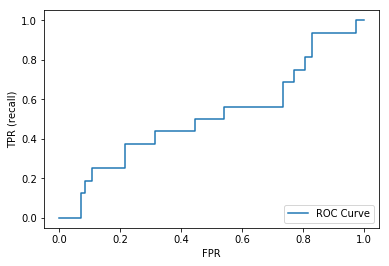

In [27]:
fpr, tpr, thresholds = roc_curve(y_target,y_corr_prob)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.legend(loc=4)

In [ ]:
def make_oneshot_task(in_groups,N):
    #"Create pairs of test image, support set for testing N way one-shot learning. "
    
    #Select 2 images from validation set of a random category
    #Select more N-1 images from validation set of different categories(Support set)
    #Make prediction
    #Repeat this process
     
    test_image,support_set_true_category_image=[],[]
    support_set, test_image_set,out_score = [],[],[]

    #Get N categories from validation set
    categories = rng.choice(len(in_groups),size=(2,),replace=False) 
    #Select one category 
    true_category = categories[0]
    #select 2 int index from n_examples per category
    a_true_images_ind,b_true_images_ind = np.random.choice(range(in_groups[true_category].shape[0]),replace=False,size=(2,));

    #select 2 image from validation set of of true_category
    test_image = in_groups[true_category][a_true_images_ind]
    support_set_true_category_image= in_groups[true_category][b_true_images_ind]
    
    #prepare support set from other random categories and indices
    #select 1 examples from every N categories 
    support_set += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in categories]      
    
    #select another image from validation set of of true_category
    support_set[true_category]=support_set_true_category_image #there will be one image for every category in support set
    test_image_set += [test_image]
    out_score += [1]
    
    for replica in range(N-1): # 1 has been done previously for the first image(from same class)
        test_image_set += [test_image]
        out_score += [0]
        
    #support_set = support_set.reshape(N,self.w,self.h,1)
    #pairs = [test_image,support_set]
    #targets = np.zeros((N,))
    #targets[0] = 1

    return np.stack(test_image_set,0), np.stack(support_set,0), np.stack(out_score,0)

In [ ]:
def test_oneshot(N,k,verbose=0):
        #"""Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        pass
        n_correct = 0
        if verbose:
            print("Evaluating model on {} unique {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            group_a, group_b, score =  make_oneshot_task(test_groups,N)
            #probs = model.predict(group_a, group_b)
            pred_sim = similarity_model.predict([group_a, group_b])
            if np.argmax(pred_sim) == 0:  #first element was same category
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct

In [ ]:
test_oneshot(2,5,verbose=0)

In [ ]:
# plot the training loss and accuracy
N = 2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), loss_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), loss_history.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), loss_history.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, N), loss_history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

_ = show_model_output()

## Neighbor Visualization
Here we aim to answer the more general question: did we generate useful features with the Feature Generation model? And how can we visualize this.
For this we use the TSNE neighborhood embedding to visualize the features on a 2D plane and see if it roughly corresponds to the groups. We use the test data for this example as well since the training has been contaminated

In [ ]:
x_test_features = feature_model.predict(x_test, verbose = True, batch_size=128)

%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=500,
                         verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)


obj_categories = ['1','2']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
                marker='o',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('dist.png')
plt.show(block=False)